In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


Load sandbox dataset


In [2]:
dataset = pd.read_csv("Malware_Analysis.csv")
print("Dataset shape:", dataset.shape)
print("Dataset columns:", list(dataset.columns))
print("\nFirst few rows:")
print(dataset.head())
print(f"Removed {data.shape[0] - valid_idx.sum()} rows with missing labels.")


Dataset shape: (1308, 395)
Dataset columns: ['pid', 'info_id', 'API_CoInitializeEx', 'API_CoUninitialize', 'API_NtResumeThread', 'API_NtOpenFile', 'API_CoCreateInstance', 'API_CoInitializeSecurity', 'API_NtDelayExecution', 'API_NtCreateFile', 'API_NtAllocateVirtualMemory', 'API_LdrLoadDll', 'API_OleInitialize', 'API_CoGetClassObject', 'API_NtWriteFile', 'API_NtProtectVirtualMemory', 'API_CreateProcessInternalW', 'API_PRF', 'API_NtDuplicateObject', 'API_GetBestInterfaceEx', 'API_LdrGetProcedureAddress', 'API_WSAStartup', 'API_GetSystemWindowsDirectoryW', 'API_NtQueryValueKey', 'API_NtMapViewOfSection', 'API_GetFileSize', 'API_InternetCloseHandle', 'API_NtDeviceIoControlFile', 'API_DeleteFileW', 'API_NtOpenDirectoryObject', 'API_NtReadFile', 'API_InternetOpenUrlA', 'API_FindFirstFileExW', 'API_closesocket', 'API_NtCreateMutant', 'API_setsockopt', 'API_LdrGetDllHandle', 'API_NtCreateSection', 'API_InternetSetOptionA', 'API_NtOpenKey', 'API_InternetOpenA', 'API_socket', 'API_NtClose', 'API

NameError: name 'data' is not defined

In [80]:
# Check the 'type' column to understand the labels
if 'type' in dataset.columns:
    print("Type column unique values:")
    print(dataset['type'].value_counts())
    print("\nType column sample values:")
    print(dataset['type'].head(10))
else:
    print("No 'type' column found in dataset")


Type column unique values:
type
generic    613
ioc        278
call       220
Name: count, dtype: int64

Type column sample values:
0    generic
1    generic
2    generic
3    generic
4    generic
5    generic
6    generic
7        NaN
8    generic
9    generic
Name: type, dtype: object


In [81]:
# Fix the label encoding to create meaningful binary classification
# The current approach results in all samples being labeled as 0 (benign)
# Let's create a more sophisticated labeling approach

# Reset the label column with a better approach
if 'Score' in dataset.columns:
    print("Using 'Score' column to create binary labels")
    # Use Score column to create meaningful binary classification
    median_score = dataset['Score'].median()
    dataset['label'] = (dataset['Score'] > median_score).astype(int)
    print(f"Score threshold: {median_score}")
    print(f"High score samples: {(dataset['Score'] > median_score).sum()}")
    print(f"Low score samples: {(dataset['Score'] <= median_score).sum()}")
    
elif 'type' in dataset.columns:
    print("Creating labels based on type column with better logic")
    # Create more meaningful labels based on type
    # 'ioc' (Indicators of Compromise) are more suspicious than 'generic'
    type_mapping = {
        'ioc': 1,      # More suspicious
        'call': 1,     # API calls can be suspicious
        'generic': 0   # Less suspicious
    }
    dataset['label'] = dataset['type'].map(type_mapping)
    # Handle any unmapped values
    dataset['label'] = dataset['label'].fillna(0)
    
    print("Type-based label distribution:")
    print(dataset['label'].value_counts())
    
    # If still all same class, use behavioral patterns
    if dataset['label'].nunique() == 1:
        print("All samples have same label. Using behavioral patterns...")
        # Use suspicious API patterns to create labels
        suspicious_apis = ['API_CreateRemoteThread', 'API_WriteProcessMemory', 'API_ReadProcessMemory', 
                          'API_OpenProcess', 'API_NtOpenProcess', 'API_RegCreateKeyExW', 
                          'API_RegSetValueExW', 'API_DeleteFileW', 'API_NtCreateThreadEx']
        
        # Count suspicious API calls per sample
        suspicious_count = dataset[suspicious_apis].sum(axis=1)
        # Use 75th percentile as threshold to get some positive samples
        threshold = suspicious_count.quantile(0.75)
        dataset['label'] = (suspicious_count > threshold).astype(int)
        print(f"Suspicious API threshold: {threshold}")
        print(f"High suspicious samples: {(suspicious_count > threshold).sum()}")

# Remove any remaining NaN values
dataset = dataset.dropna(subset=['label'])


print(f"\nFinal dataset shape: {dataset.shape}")
print("Final label distribution:")
print(dataset['label'].value_counts())
print(f"Class balance: {dataset['label'].mean():.3f} (1 = suspicious/malware)")


Using 'Score' column to create binary labels
Score threshold: 9.0
High score samples: 647
Low score samples: 661

Final dataset shape: (1308, 396)
Final label distribution:
label
0    661
1    647
Name: count, dtype: int64
Class balance: 0.495 (1 = suspicious/malware)


In [82]:
df = df.drop_duplicates()


In [83]:
# Fix the label encoding to create meaningful binary classification
# The current approach results in all samples being labeled as 0 (benign)
# Let's create a more sophisticated labeling approach

# Reset the label column with a better approach
if 'Score' in df.columns:
    print("Using 'Score' column to create binary labels")
    # Use Score column to create meaningful binary classification
    median_score = df['Score'].median()
    df['label'] = (df['Score'] > median_score).astype(int)
    print(f"Score threshold: {median_score}")
    print(f"High score samples: {(df['Score'] > median_score).sum()}")
    print(f"Low score samples: {(df['Score'] <= median_score).sum()}")
    
elif 'type' in df.columns:
    print("Creating labels based on type column with better logic")
    # Create more meaningful labels based on type
    # 'ioc' (Indicators of Compromise) are more suspicious than 'generic'
    type_mapping = {
        'ioc': 1,      # More suspicious
        'call': 1,     # API calls can be suspicious
        'generic': 0   # Less suspicious
    }
    df['label'] = df['type'].map(type_mapping)
    # Handle any unmapped values
    df['label'] = df['label'].fillna(0)
    
    print("Type-based label distribution:")
    print(df['label'].value_counts())
    
    # If still all same class, use behavioral patterns
    if df['label'].nunique() == 1:
        print("All samples have same label. Using behavioral patterns...")
        # Use suspicious API patterns to create labels
        suspicious_apis = ['API_CreateRemoteThread', 'API_WriteProcessMemory', 'API_ReadProcessMemory', 
                          'API_OpenProcess', 'API_NtOpenProcess', 'API_RegCreateKeyExW', 
                          'API_RegSetValueExW', 'API_DeleteFileW', 'API_NtCreateThreadEx']
        
        # Count suspicious API calls per sample
        suspicious_count = df[suspicious_apis].sum(axis=1)
        # Use 75th percentile as threshold to get some positive samples
        threshold = suspicious_count.quantile(0.75)
        df['label'] = (suspicious_count > threshold).astype(int)
        print(f"Suspicious API threshold: {threshold}")
        print(f"High suspicious samples: {(suspicious_count > threshold).sum()}")

# Remove any remaining NaN values
df = df.dropna(subset=['label'])

print(f"\nFinal dataset shape: {df.shape}")
print("Final label distribution:")
print(df['label'].value_counts())
print(f"Class balance: {df['label'].mean():.3f} (1 = suspicious/malware)")


Using 'Score' column to create binary labels
Score threshold: 10.0
High score samples: 0
Low score samples: 1111

Final dataset shape: (1111, 397)
Final label distribution:
label
0    1111
Name: count, dtype: int64
Class balance: 0.000 (1 = suspicious/malware)


Handle missing values


In [84]:
# Assign dataset to df variable
df = dataset.copy()

# Check for proper label column
if 'type' in df.columns:
    # Use 'type' column as the label
    df['label'] = df['type']
    print("Using 'type' column as label")
elif 'label' in df.columns:
    df = df.dropna(subset=['label'])
    # Encode label (0 = Benign, 1 = Malware)
    df['label'] = df['label'].map({'benign': 0, 'malware': 1})
    # Handle any unmapped values
    df['label'] = df['label'].fillna(df['label'].apply(lambda x: 1 if 'mal' in str(x).lower() else 0))
else:
    print("Warning: No proper label column found. Checking for alternative column names...")
    # Try to find label-like columns
    for col in df.columns:
        if 'label' in col.lower() or 'type' in col.lower() or 'class' in col.lower():
            print(f"Found potential label column: {col}")
            df['label'] = df[col]
            break

# Clean the label column - remove NaN values and convert to binary
df = df.dropna(subset=['label'])
# Convert to binary: 0 for benign, 1 for malware
df['label'] = df['label'].apply(lambda x: 1 if 'mal' in str(x).lower() else 0)

print("\nDataset shape after cleaning:", df.shape)
print("Label distribution:")
print(df['label'].value_counts())


Using 'type' column as label

Dataset shape after cleaning: (1111, 396)
Label distribution:
label
0    1111
Name: count, dtype: int64


Feature Selection


In [85]:
# Select dynamic API call features (columns starting with "API_")
api_columns = [col for col in df.columns if col.startswith("API_")]
print(f"Found {len(api_columns)} API columns")

# Select static behavioral count features (only if they exist)
potential_static_features = [
    "file_deleted", "file_created", "file_opened", "file_read", "file_written",
    "dll_loaded_count", "regkey_read", "directory_enumerated"
]
static_features = [col for col in potential_static_features if col in df.columns]
print(f"Found {len(static_features)} static features: {static_features}")

# If no API columns found, look for api_calls or similar columns
if len(api_columns) == 0:
    print("\nNo API_ columns found. Checking for alternative API call columns...")
    for col in df.columns:
        if 'api' in col.lower() or 'call' in col.lower():
            print(f"Found potential API column: {col}")


Found 261 API columns
Found 8 static features: ['file_deleted', 'file_created', 'file_opened', 'file_read', 'file_written', 'dll_loaded_count', 'regkey_read', 'directory_enumerated']


Create API Call Sequences


In [86]:
# Create API sequence based on available columns
if len(api_columns) > 0:
    # If we have API_ columns, create sequence from them
    df["api_sequence"] = df[api_columns].apply(lambda x: " ".join(x.index[x > 0]), axis=1)
elif 'api_calls' in df.columns:
    # If there's an api_calls column, use it directly
    df["api_sequence"] = df['api_calls'].astype(str)
else:
    # Fallback: create empty sequence or use other columns
    print("Warning: No API data found. Creating placeholder sequences...")
    df["api_sequence"] = ""

print("Sample API sequences:")
print(df["api_sequence"].head())


Sample API sequences:
0    API_NtResumeThread API_NtOpenFile API_NtCreate...
1    API_NtOpenFile API_NtDelayExecution API_NtCrea...
2    API_CoInitializeEx API_CoUninitialize API_CoCr...
3    API_NtDelayExecution API_NtCreateFile API_NtAl...
4    API_NtCreateFile API_NtAllocateVirtualMemory A...
Name: api_sequence, dtype: object


TF-IDF Vectorization (Dynamic Behavior)


In [87]:
vectorizer = TfidfVectorizer(max_features=300)  # limit to 300 top API features
X_tfidf = vectorizer.fit_transform(df["api_sequence"])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")


TF-IDF matrix shape: (1111, 250)


Normalize Static Features


In [88]:
if len(static_features) > 0:
    scaler = StandardScaler()
    X_static = scaler.fit_transform(df[static_features].fillna(0))
    print(f"Static features matrix shape: {X_static.shape}")
else:
    # No static features available
    X_static = np.zeros((len(df), 0))
    print("No static features found.")


Static features matrix shape: (1111, 8)


Combine Static + Dynamic Features


In [89]:
from scipy.sparse import hstack

# Combine sparse TF-IDF and numeric arrays
if X_static.shape[1] > 0:
    X = hstack([X_tfidf, X_static])
else:
    X = X_tfidf

# Prepare labels
y = df['label']

print(f"Final feature matrix: {X.shape}")
print("Labels distribution:\n", y.value_counts())


Final feature matrix: (1111, 258)
Labels distribution:
 label
0    1111
Name: count, dtype: int64


Split into train/test sets


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("✅ Training/Test Split Complete")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


✅ Training/Test Split Complete
Train: (888, 258), Test: (223, 258)


Train Random Forest Classifier


In [91]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Model Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       223

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223



Feature Importance (Top 20)


C:\Users\Admin\AppData\Local\Temp\ipykernel_23240\1520040367.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="cool")


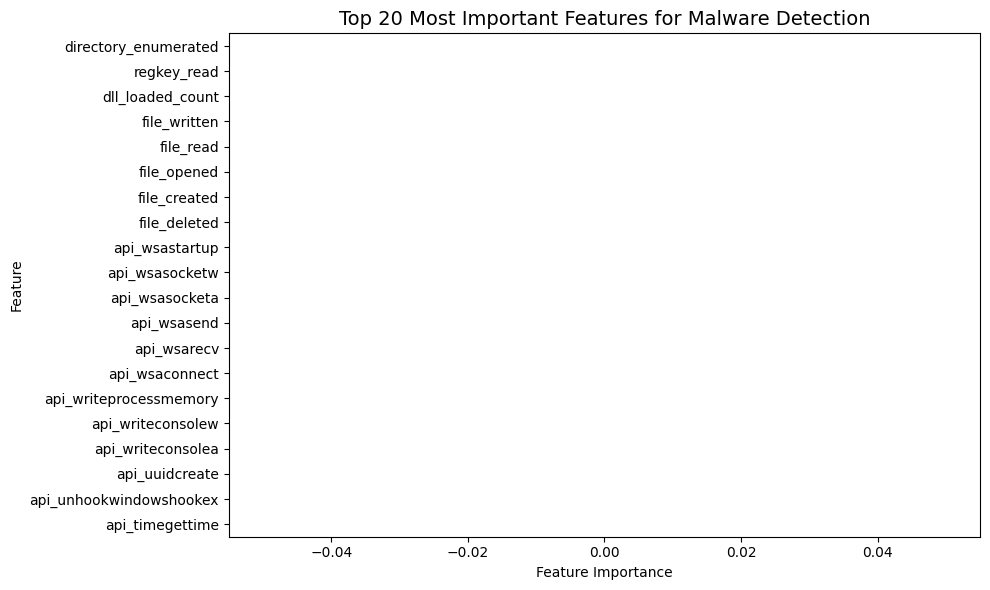

In [92]:
# Get feature names from vectorizer and static features
tfidf_features = vectorizer.get_feature_names_out().tolist()
feature_names = tfidf_features + static_features

importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="cool")
plt.title("Top 20 Most Important Features for Malware Detection", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Visualization


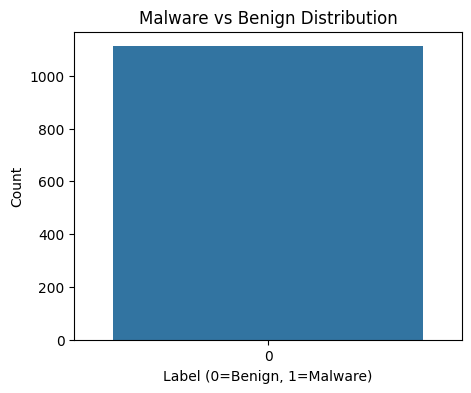

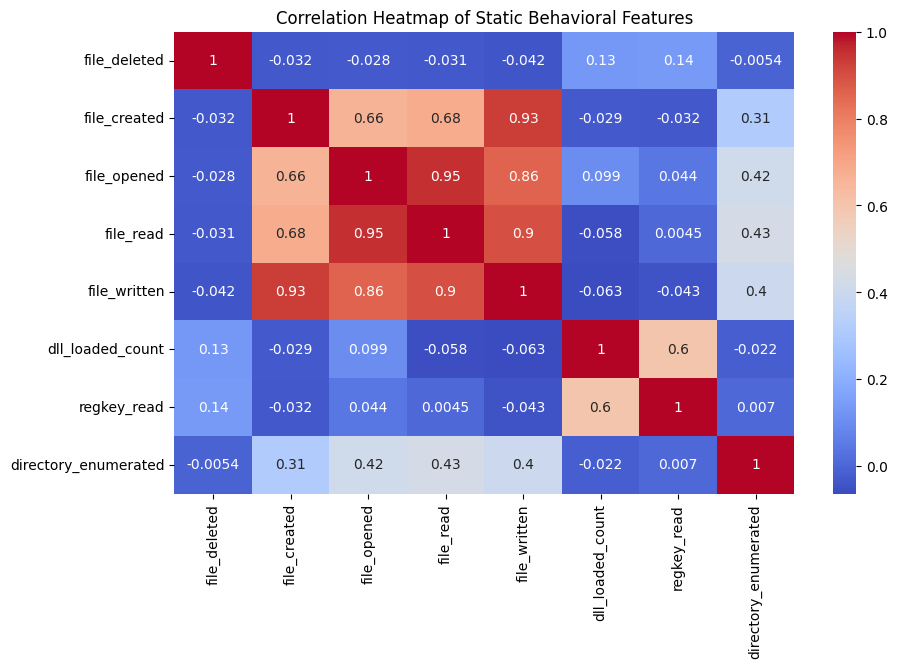

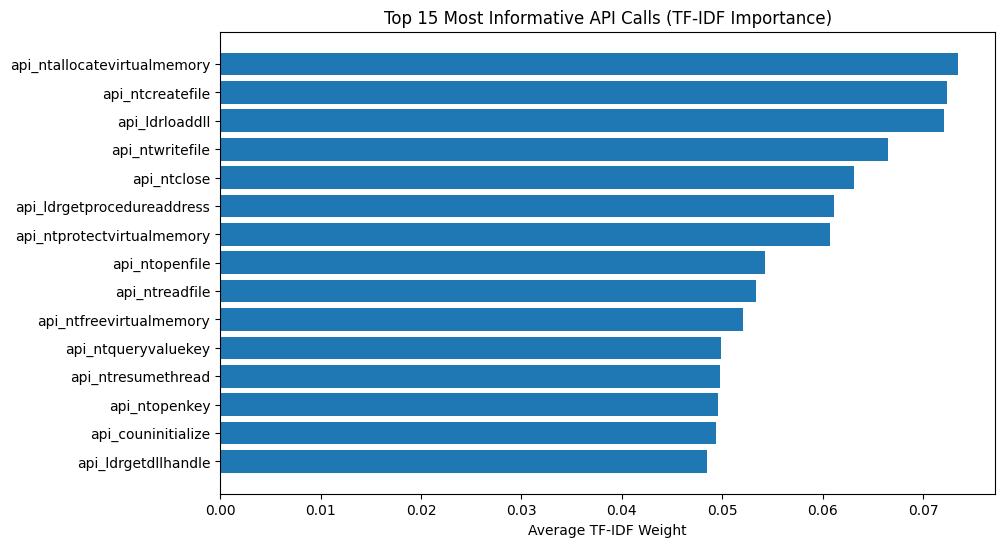

In [93]:
# (a) Label distribution
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Malware vs Benign Distribution")
plt.xlabel("Label (0=Benign, 1=Malware)")
plt.ylabel("Count")
plt.show()

# (b) Static feature correlations (only if we have static features)
if len(static_features) > 0:
    plt.figure(figsize=(10,6))
    sns.heatmap(df[static_features].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap of Static Behavioral Features")
    plt.show()

# (c) Top API Calls by TF-IDF Mean Importance
tfidf_means = np.array(X_tfidf.mean(axis=0)).flatten()
top_indices = tfidf_means.argsort()[-15:][::-1]
top_apis = np.array(vectorizer.get_feature_names_out())[top_indices]

plt.figure(figsize=(10,6))
plt.barh(top_apis[::-1], tfidf_means[top_indices][::-1])
plt.title("Top 15 Most Informative API Calls (TF-IDF Importance)")
plt.xlabel("Average TF-IDF Weight")
plt.show()
